## Import

In [1]:
import sys
sys.path.append(r'\\Pund\Stab$\guest801968\Documents\GitHub\GeoSpatial-analysis\facility-location-Bergen\src\facility_location_Bergen\custome_modules')

In [2]:
import pickle as pkl
import plotly.graph_objects as go
import plotly.express as px
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import numpy as np
import networkx as nx
# import facility_location
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
def show_graph(F, display_jam=False, free_flow=False, fig=None):
  if type(F) != list:
    F = [F]
  
  colors = ["blue", "red", "green", "yellow", "orange", "purple", "brown"]
  
  if fig is None:
    fig = go.Figure()

  for j, f in enumerate(F):
    if j < len(colors):
      color = colors[j]
    else:
      color = "black"
      
    nodes_lon = []
    nodes_lat = []
    diff_weights = []
    for edge in f.edges(data=True):
          x0, y0 = edge[0]
          x1, y1 = edge[1]
          weight = edge[2]["weight"]
          weight2 = edge[2]["weight2"]
          nodes_lon.append(x0)
          nodes_lon.append(x1)
          nodes_lon.append(None)
          nodes_lat.append(y0)
          nodes_lat.append(y1)
          nodes_lat.append(None)
          diff_weights.append(abs(weight2 - weight) / weight2)
    
    nodes_lon_color = {"green": [], "gold": [], "orange": [], "red": []}
    nodes_lat_color = {"green": [], "gold": [], "orange": [], "red": []}

    
    for i, weight in enumerate(diff_weights):
      mapped_weight = stats.percentileofscore(diff_weights, weight) / 100
      if mapped_weight < 0.25:
        nodes_lon_color["green"] += nodes_lon[i*3:i*3+3]
        nodes_lat_color["green"] += nodes_lat[i*3:i*3+3]
      elif mapped_weight < 0.5:
        nodes_lon_color["gold"] += nodes_lon[i*3:i*3+3]
        nodes_lat_color["gold"] += nodes_lat[i*3:i*3+3]
      elif mapped_weight < 0.75:
        nodes_lon_color["orange"] += nodes_lon[i*3:i*3+3]
        nodes_lat_color["orange"] += nodes_lat[i*3:i*3+3]
      else:
        nodes_lon_color["red"] += nodes_lon[i*3:i*3+3]
        nodes_lat_color["red"] += nodes_lat[i*3:i*3+3]
  
    if display_jam and not free_flow:
      for key in nodes_lon_color.keys():
        fig.add_trace(go.Scattermapbox(
              lat=nodes_lat_color[key],
              lon=nodes_lon_color[key],
              mode='lines',
              line=dict(width=1, color=key),
              showlegend=False,
          ))
    else:
      fig.add_trace(go.Scattermapbox(
          lat=nodes_lat,
          lon=nodes_lon,
          mode='lines',
          line=dict(width=1, color=color),
          showlegend=False,
      ))

      nodes = f.nodes()
      nodes = gpd.GeoDataFrame(pd.Series(list(nodes())).apply(lambda x: Point(x)), columns=["geometry"], crs="EPSG:4326")


      fig.add_trace(go.Scattermapbox(
      lat = nodes.geometry.y,
      lon = nodes.geometry.x,
      mode='markers',
      marker=dict(size=2, color="black"),
      showlegend=False,
    ))
  
  if display_jam:
    style = "carto-positron"
  else:
    style = "open-street-map"
  fig.update_layout(title="<b>Graph visualization<b>",
                        mapbox=dict(
                          style=style,
                          center=dict(lat=np.mean(pd.Series(nodes_lat).dropna()), lon=np.mean(pd.Series(nodes_lon).dropna())),
                          zoom=9
                          ),
                        title_pad_l=260,
                        height=700,
                        width=1000,)

  return  fig

In [4]:
def build_cc(G, strong=False):
    if not strong:
        if nx.is_directed(G):
            G = G.to_undirected()
        CCs = [nx.DiGraph(G.subgraph(c).copy()) for c in sorted(nx.connected_components(G), reverse=True, key=len)]
    else:
        CCs = [G.subgraph(c).copy() for c in sorted(nx.strongly_connected_components(G), reverse=True, key=len)]
    return CCs

In [8]:
root = r"C:\Users\guest801968\Downloads"
# with open(root+r"\history_changes_refine.pkl", "rb") as f:
#     history = pkl.load(f)
    
# with open(root+r"\graph_refine_all_day.pkl", "rb") as f:
#     G = pkl.load(f)
    
with open(root+r"\graph_final_dict.pkl", "rb") as f:
    G_dict = pkl.load(f)
    
G_dict_2 = {}
root_2 = r"\\Pund\Stab$\guest801968\Documents\GitHub\GeoSpatial-analysis\facility-location-Bergen\data\03_primary"
file_names = ["all_day", "morning", "midday", "afternoon"]
for file in file_names:
    with open(root_2+r"\average_graph_"+file+"_connected_splitted.pkl", "rb") as f:
        G_dict_2[file] = pkl.load(f)

In [10]:
# for k, v in G_dict.items():
#     with open(root+r"\graph_final_"+k+".pkl", "wb") as f:
#         pkl.dump(v, f)

In [7]:
# root = r"C:\Users\guest801968\Downloads"
# with open(root+r"\graph_final_dict.pkl", "wb") as f:
#     pkl.dump(G_dict_2, f)

In [10]:
root = rf"\/Pund\Stab$/guest801968/Documents/GitHub/GeoSpatial-analysis/facility-location-Bergen/data/03_primary"
times = ["all_day", "morning", "midday", "afternoon"]

In [86]:
print("saving average graphs")
for time in times:
    if time != "all_day_free_flow":
        print(f"average graphs for {time}")
        path = root + f"/average_graph_{time}_connected_splitted.pkl"
        with open(path, "wb") as f:
            pkl.dump(G_dict[time], f)

loading average graphs
average graphs for all_day
average graphs for morning
average graphs for midday
average graphs for afternoon


In [11]:
print("saving average graphs first cc")
for time in times:
    if time != "all_day_free_flow":
        print(f"average graphs for {time}")
        path = root + f"/average_graph_{time}_connected_splitted_firstSCC.pkl"
        CCs = build_cc(G_dict[time], strong=True)
        CC0 = CCs[0]
        with open(path, "wb") as f:
            pkl.dump(CC0, f)

saving average graphs first cc
average graphs for all_day
average graphs for morning
average graphs for midday
average graphs for afternoon


In [76]:
for e_all in G_dict["all_day"].edges(data=True):
    for e_morning in G_dict_2["morning"].edges(data=True):
        if e_all[0] == e_morning[0] and e_all[1] == e_morning[1]:
            if e_all[2]["weight"] == e_morning[2]["weight"]:
                print("all_day","|" " morning")
                print(round(e_all[2]["weight"],4), "  | ", round(e_morning[2]["weight"],4))

all_day | morning
28.44   |  28.44


In [13]:
CCs = {}
for time in times:
    if time != "all_day_free_flow":
        print(f"average graphs for {time}")
        path = root + f"/average_graph_{time}_connected_splitted_firstSCC.pkl"
        with open(path, "rb") as f:
            CCs[time] = pkl.load(f)

average graphs for all_day
average graphs for morning
average graphs for midday
average graphs for afternoon


In [101]:
G = CCs["all_day"]

In [102]:
bi_edges = []
for edge in G.edges(data=False):
    if (edge[1], edge[0]) in G.edges(data=False) and edge[0] != edge[1] and (edge[1], edge[0]) not in bi_edges:
        bi_edges.append(edge)
len(bi_edges)

0

In [103]:
nx.number_connected_components(G.to_undirected())

1

In [104]:
nx.number_strongly_connected_components(G)

1

In [61]:
CCs = build_cc(G, strong=True)
CCs_ = [G]+CCs

In [11]:
show_graph(CCs[0])

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'lat': [60.42212, 60.422659, None, ..., 60.39388, 60.39385, None],
              'line': {'color': 'red', 'width': 1},
              'lon': [5.51596, 5.513479, None, ..., 5.318425, 5.31867, None],
              'mode': 'lines',
              'showlegend': False,
              'type': 'scattermapbox'},
             {'lat': array([60.42212 , 60.42221 , 60.42231 , ..., 60.393875, 60.393893, 60.39388 ]),
              'lon': array([5.51596 , 5.51631 , 5.51624 , ..., 5.318745, 5.318688, 5.318425]),
              'marker': {'color': 'black', 'opacity': 1, 'size': 3},
              'mode': 'markers',
              'showlegend': False,
              'text': [0, 1, 2, ..., 9869, 9870, 9871],
              'type': 'scattermapbox'}],
    'layout': {'height': 700,
               'mapbox': {'center': {'lat': 60.366746, 'lon': 5.336089}, 'style': 'open-street-map', 'zoom': 9},
               'template': '...',
               'title': {'pad': {'l': 260}, 'text': '<b>Graph visualization<b>'},
               'width': 1000}
})

In [32]:
CCs["all_day"].edges((5.45132, 60.43784))

OutEdgeDataView([((5.45132, 60.43784), (5.45512, 60.42724))])

In [31]:
CCs["all_day"].edges((5.45133, 60.43999))

OutEdgeDataView([((5.45133, 60.43999), (5.45132, 60.43784))])

In [13]:
CCs["all_day"].edges((5.424421, 60.45976))

OutEdgeDataView([((5.424421, 60.45976), (5.424971, 60.45979))])

In [14]:
CCs["all_day"].edges((5.424408, 60.46024))

OutEdgeDataView([((5.424408, 60.46024), (5.42442, 60.45983)), ((5.424408, 60.46024), (5.424421, 60.45976))])

In [15]:
CCs["all_day"].edges((5.424421, 60.45983))

OutEdgeDataView([((5.424421, 60.45983), (5.42441, 60.46024)), ((5.424421, 60.45983), (5.42358, 60.45985))])

In [16]:
CCs["all_day"].edges((5.42497, 60.45984))

OutEdgeDataView([((5.42497, 60.45984), (5.42441, 60.46024)), ((5.42497, 60.45984), (5.424421, 60.45983))])

In [26]:
gen = nx.all_simple_paths(CCs["all_day"], (5.3639, 60.30903),(5.4492, 60.44748))

## Solution analysis

In [16]:
root = r"\\Pund\Stab$\guest801968\Documents\GitHub\GeoSpatial-analysis\facility-location-Bergen\data\07_model_output\1_locations\deterministic_exact_solutions"
times = ["all_day_free_flow", "all_day", "morning", "midday", "afternoon"]

In [17]:
exact_solution = {}
for time in times:
    print(f"average graphs for {time}")
    path = root + f"\\light_exact_solution_{time}.pkl"
    with open(path, "rb") as f:
        exact_solution[time] = pkl.load(f)

average graphs for all_day_free_flow
average graphs for all_day
average graphs for morning
average graphs for midday
average graphs for afternoon


In [9]:
exact_solution["all_day_free_flow"].__dict__.keys()

dict_keys(['coordinates', 'candidate_coordinates', 'n_of_locations_to_choose', 'adjacency_matrix_weight', 'n_of_demand_points', 'result', 'solution_value', 'locations_index', 'locations_coordinates', 'solver_status', 'computation_time', 'algorithm'])

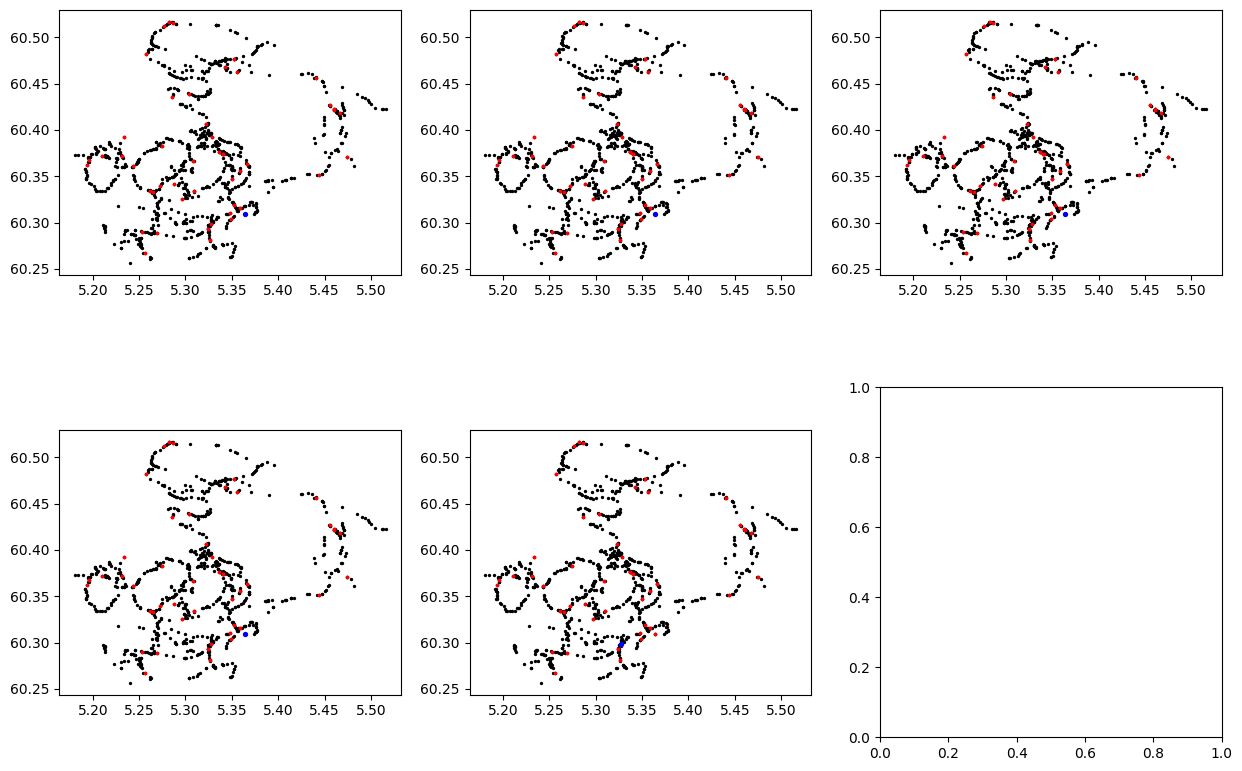

In [18]:
fig, axs = plt.subplots(2,3, figsize=(15,10))
for i, ax_row in enumerate(axs):
    for j, ax in enumerate(ax_row):
        if i*3+j < len(times):
            coord = exact_solution[times[i*3+j]].coordinates
            candidate_coord = exact_solution[times[i*3+j]].candidate_coordinates
            sol_loc = exact_solution[times[i*3+j]].locations_coordinates[0]
            coord.plot(ax=ax, color="black", markersize=2)
            candidate_coord.plot(ax=ax, color="red", markersize=3)
            ax.scatter(sol_loc.iloc[0].x, sol_loc.iloc[0].y, color="blue", s=8)

## Traffic JAM

In [ ]:
fig = show_graph(G_dict_2["morning"], display_jam=True, free_flow=False)
fig

In [ ]:
fig = show_graph(G_dict_2["morning"])
fig